In [39]:
import pandas as pd
import numpy as np
import math
from geopy.distance import geodesic
from scipy.spatial import ConvexHull
from scipy.spatial import distance
import geopandas as gpd
import time
import networkx as nx
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

# 读取数据并预处理

In [40]:
od_nanshan=pd.read_csv('../data/nanshan_OD.csv')

In [41]:
grouped = od_nanshan.groupby(['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])
# Calculate group sizes
group_sizes = grouped.size()
# Reset the group sizes to a DataFrame
df_grouped = group_sizes.reset_index(name='count').sort_values('count', ascending=False).reset_index()

df_grouped['lng']=df_grouped.apply(lambda row: (row['origin_lng'] + row['destination_lng']) / 2, axis=1)
df_grouped['lat']=df_grouped.apply(lambda row: (row['origin_lat'] + row['destination_lat']) / 2, axis=1)
df_grouped['id']=np.arange(len(df_grouped))
df_grouped.head(2)

,index,origin_lat,origin_lng,destination_lat,destination_lng,count,lng,lat,id
0,29194,22.522953,113.928162,22.532340,113.938431,123,113.933297,22.527647,0
1,35962,22.532879,113.957593,22.523626,113.948245,111,113.952919,22.528253,1


# 空间相似性函数

In [42]:
def readData(df):
    od_coordinates = list(zip(df['origin_lat'], df['origin_lng'], df['destination_lat'], df['destination_lng']))
    return od_coordinates

#计算cluster的中心流坐标
def calcClusterFlow(cluster, data):
    ox = 0
    oy = 0
    dx = 0
    dy = 0
    for k in cluster:
        ox += data[k][0]
        oy += data[k][1]
        dx += data[k][2]
        dy += data[k][3]
    d = float(len(cluster))
            
    ox /= d
    oy /= d
    dx /= d
    dy /= d
    return ox, oy, dx, dy

# 计算两个类的空间相似性:方向与长度
def flowSim(vi, vj, centerv, alpha):
    leni = math.sqrt((vi[0]**2+vi[1]**2))
    lenj = math.sqrt((vj[0]**2+vj[1]**2))
    dv = math.sqrt((vi[0] - vj[0]) ** 2 + (vi[1] - vj[1]) ** 2)
    dcenterv = math.sqrt(centerv[0]**2+centerv[1]**2)

    if leni > lenj:
        return max(dv,dcenterv)/(alpha*leni)
    else:
        return max(dv,dcenterv)/(alpha*lenj)

    
#计算clusterID为ci和cj的两个类的相似性
def clusterSim(ci, cj, data, alpha):
    oix, oiy, dix, diy = calcClusterFlow(ci, data)
    ojx, ojy, djx, djy = calcClusterFlow(cj, data)

    center_ix,center_iy=(oix+dix)/2,(oiy+diy)/2
    center_jx,center_jy=(ojx+djx)/2,(ojy+djy)/2
    centerv=[center_ix-center_jx,center_iy-center_jy]

    vi = [dix-oix, diy-oiy]
    vj = [djx-ojx, djy-ojy]
    
    return flowSim(vi, vj, centerv, alpha)

#合并相似度高的类
def merge(cluster, ci, cj, l):
    """
    {cluster(类id):流的id}
    l:每一个流对应哪一类
    """
    #保留小数字的clusterID
    if ci > cj:
        ci, cj = cj, ci
        
    for lid in cluster[cj]:
        l[lid] = ci
        cluster[ci].append(lid)
    cluster.pop(cj)

In [43]:
# 构造坐标列表
coords = df_grouped[['lng', 'lat']].values

# 计算第i个数据中点的k个近邻点,返回近邻点序号列表
def KNN(id,k):
    # 获取指定id的midpnt坐标
    coord = df_grouped[df_grouped['id'] == id][['lng', 'lat']].values
    # 使用 sklearn 的 NearestNeighbors 计算近邻
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(coords)
    # 查询 k 个近邻
    distances, indices = nbrs.kneighbors(coord)
    # 剔除自身，返回k个近邻的id列表
    return df_grouped.loc[indices[0][1:]]['id'].tolist()

# 流聚类

In [44]:
# 空间聚类参数
alpha = 0.1     # 边界圆尺度系数
k = 25           # 近邻数

# 读取数据并初始化
od_coordinates=readData(df_grouped)
dataLen = len(od_coordinates)
print(dataLen)
c = {} #类集合
l = [] #数据标签集合

39757


In [45]:
#----------------------------空间聚类----------------------------------
# 初始化时第i类只包括第i个数据，第i个数据的数据标签为第i类
for i in range(dataLen):
    c[i] = [i]  # 类编号(整数编号)，包含的流编号
    l.append(i)  # 流的类标签

print('start clustering...')
st = time.clock()
for i in range(dataLen):
    if i%5000 == 0:
        et = time.clock()
        print(i, '%.2f' % ((et-st)/60.0), 'mins')
    
    knn = KNN(i, k) #计算k近邻点

    for j in knn:
        if l[i] != l[j]: #如果第i条流和第j条流不属于同一类
            try:
                if not (clusterSim(c[l[i]], c[l[j]], od_coordinates, alpha) > 1):
                    merge(c, l[i], l[j], l)
            except:
                print("id {} not exist".format(j))
                continue
print("流聚类后的label数量为{}".format(len(set(l))))

start clustering...
0 0.00 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


5000 2.62 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


10000 5.17 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


15000 7.69 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


20000 10.22 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


25000 12.77 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


30000 15.29 mins


e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


35000 17.84 mins
流聚类后的label数量为32252


In [46]:
df_grouped['cluster']=l
df_grouped.to_csv('../data/grouped_od.csv',index=False)

In [47]:
df_grouped=pd.read_csv('../data/grouped_od.csv')
df_grouped.head(2)

,index,origin_lat,origin_lng,destination_lat,destination_lng,count,lng,lat,id,cluster
0,29194,22.522953,113.928162,22.532340,113.938431,123,113.933297,22.527647,0,0
1,35962,22.532879,113.957593,22.523626,113.948245,111,113.952919,22.528253,1,1


# 中心流

In [48]:
def outputSClusterData(df_grouped,od_coordinates, c):
    centerFlow_df = pd.DataFrame()
    for i in c.keys():
        if len(c[i]) > 0:
            origin_lat,origin_lng,destination_lat,destination_lng = calcClusterFlow(c[i], od_coordinates)

            id_list=c[i]
            total_count = df_grouped[df_grouped['id'].isin(id_list)]['count'].sum()

            # 将数据添加到 DataFrame
            centerFlow_df = centerFlow_df.append({'clusterID': i, 'ori_lat': origin_lat, 'ori_lng': origin_lng, 'dest_lat': destination_lat, 'dest_lng': destination_lng, 
                                            'flowNum': len(c[i]), 'flowCount': total_count}, ignore_index=True)
    return centerFlow_df

In [49]:
centerflow_df=outputSClusterData(df_grouped,od_coordinates,c)
# centerflow_df['sqrt_flow_count']= centerflow_df.apply(lambda row: math.sqrt(row['flowCount']), axis=1)
centerflow_df.to_csv('../data/centerFlow.csv',index=False)

In [50]:
centerflow_df=pd.read_csv('../data/centerFlow.csv')
centerflow_df.head(2)

,clusterID,ori_lat,ori_lng,dest_lat,dest_lng,flowNum,flowCount
0,0.0,22.522747,113.928111,22.532340,113.938431,2.0,127.0
1,1.0,22.532879,113.957593,22.523626,113.948245,1.0,111.0


# OD点聚类

## 选择count大于特定值的

In [51]:
tda_center_flow=centerflow_df[centerflow_df.flowCount>45]
print("流聚类数量为{}".format(len(tda_center_flow)))
tda_cluster_id=tda_center_flow['clusterID']
flow_id=[]
for i in tda_cluster_id:
    flow_id.extend(c[i])
tda_flow_df=df_grouped[df_grouped['id'].isin(flow_id)]
print("停留点数量为{}".format(len(tda_flow_df)))
tda_flow_df

流聚类数量为72
停留点数量为148


,index,origin_lat,origin_lng,destination_lat,destination_lng,count,lng,lat,id,cluster
0,29194,22.522953,113.928162,22.532340,113.938431,123,113.933297,22.527647,0,0
1,35962,22.532879,113.957593,22.523626,113.948245,111,113.952919,22.528253,1,1
2,29769,22.523626,113.948245,22.532879,113.957593,111,113.952919,22.528253,2,2
3,20365,22.514454,113.918410,22.532106,113.918518,110,113.918464,22.523280,3,3
4,21069,22.514906,113.939209,22.523626,113.948245,107,113.943727,22.519266,4,4
...,...,...,...,...,...,...,...,...,...,...
30286,1756,22.486025,113.910248,22.491048,113.925449,1,113.917849,22.488536,30286,397
33932,19702,22.513967,113.940906,22.535169,113.959518,1,113.950212,22.524568,33932,25
34146,21061,22.514906,113.939209,22.522542,113.928061,1,113.933635,22.518724,34146,9
34178,21119,22.514906,113.939209,22.530696,113.938365,1,113.938787,22.522801,34178,32


In [52]:
tda_flow_df.to_csv('../data/test_flow.csv',index=False)
tda_center_flow.to_csv('../data/test_center_flow.csv',index=False)

In [53]:
tda_flow_df=pd.read_csv('../data/test_flow.csv')
tda_center_flow=pd.read_csv('../data/test_center_flow.csv')

In [54]:
origin_od = pd.merge(od_nanshan, tda_flow_df, 
                        on=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'],
                        how='inner')

print("匹配的行数量为: {}".format(len(origin_od)))
origin_od

匹配的行数量为: 4785


,who,origin_lat,origin_lng,destination_lat,destination_lng,age,gender,index,count,lng,lat,id,cluster
0,2427,22.510075,113.924313,22.500896,113.924633,8,1,16659,6,113.924473,22.505485,3146,83
1,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83
2,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83
3,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83
4,73458225,22.510075,113.924313,22.500896,113.924633,9,2,16659,6,113.924473,22.505485,3146,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,62589989,22.522281,113.908279,22.532106,113.918518,7,1,27836,3,113.913398,22.527193,8888,10
4781,62589989,22.522281,113.908279,22.532106,113.918518,7,1,27836,3,113.913398,22.527193,8888,10
4782,67438599,22.515233,113.927140,22.514906,113.939209,6,2,21638,2,113.933174,22.515069,11914,57
4783,76641691,22.515233,113.927140,22.514906,113.939209,12,2,21638,2,113.933174,22.515069,11914,57


### 对起止点与高维属性进行聚类，得到拓扑点

In [55]:
def pointCluster(coords, label, tmp, attr_col):
    kms_per_radian = 6371.0088  # 球上每弧度大约等于6371.0088公里
    epsilon = 0.1 / kms_per_radian  # 邻域大小转换为弧度
    # 基于坐标进行DBSCAN聚类
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    
    # 将基于距离的聚类结果添加到DataFrame
    tmp[label] = cluster_labels
    
    # 初始化一个新列来存储综合标签（距离聚类+属性）
    combined_label = label + '_attr'
    tmp[combined_label] = np.nan
    
    # 对每个距离聚类，根据额外的属性进行进一步的分组
    for cl in np.unique(cluster_labels):
        sub_df = tmp[tmp[label] == cl]  # 提取特定聚类的子集
        attrs = sub_df[attr_col].unique()  # 获取该聚类中存在的属性类型
        for attr in attrs:
            # 为每个属性类型分配一个唯一标签
            attr_label = f"{cl}_{attr}"
            tmp.loc[(tmp[label] == cl) & (tmp[attr_col] == attr), combined_label] = attr_label
            
    return tmp

In [56]:
unique_cluster_ids = origin_od['cluster'].unique()

od_cluster_df=pd.DataFrame()
for cluster_id in unique_cluster_ids:
    tmp = origin_od[origin_od['cluster']==cluster_id]

    coords1 = tmp[['origin_lat', 'origin_lng']].values
    coords2 = tmp[['destination_lat', 'destination_lng']].values
    extra_attribute = 'gender'

    pointCluster(coords1, 'ori_label', tmp, extra_attribute) # assume extra_attribute is discrete
    pointCluster(coords2, 'dest_label', tmp, extra_attribute)
    od_cluster_df=pd.concat([od_cluster_df,tmp])

e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
e:\Anaconda\envs\django\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [57]:
od_cluster_df['ori_cluster'] = od_cluster_df.groupby(['cluster', 'ori_label_attr']).ngroup()
od_cluster_df['dest_cluster'] = od_cluster_df.groupby(['cluster', 'dest_label_attr']).ngroup()+1+max(od_cluster_df.ori_cluster)
od_cluster_df = od_cluster_df.drop(['ori_label','dest_label','ori_label_attr','dest_label_attr'],axis=1)
od_cluster_df

,who,origin_lat,origin_lng,destination_lat,destination_lng,age,gender,index,count,lng,lat,id,cluster,ori_cluster,dest_cluster
0,2427,22.510075,113.924313,22.500896,113.924633,8,1,16659,6,113.924473,22.505485,3146,83,143,311
1,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83,143,311
2,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83,143,311
3,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83,143,311
4,73458225,22.510075,113.924313,22.500896,113.924633,9,2,16659,6,113.924473,22.505485,3146,83,144,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4725,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277
4726,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277
4727,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277
4728,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277


### 得到聚类后点的最小包络圆

In [58]:
def convexCircle(points):
    hull = ConvexHull(points)
    # 计算凸包的中心点
    c_lat = np.mean(hull.points[hull.vertices,0])
    c_lon = np.mean(hull.points[hull.vertices,1])
    # 计算最小包围圆的半径
    dists = [distance.euclidean([x, y], [c_lat, c_lon]) for x, y in points]
    r = np.max(dists)
    return c_lon,c_lat,r

In [59]:
def addCircleToDataframe(label,od_cluster_df,result):
    od_cluster_grouped_df = od_cluster_df.groupby(label)
    if label == 'dest_cluster':
        for name, group in od_cluster_grouped_df:
            if len(group[['destination_lat', 'destination_lng']].drop_duplicates()) > 2:
                points = group[['destination_lat', 'destination_lng']].values
                c_lon,c_lat,r = convexCircle(points)
                result.loc[len(result)]=[name,c_lon,c_lat,r]
    else:
        for name, group in od_cluster_grouped_df:
            if len(group[['origin_lat', 'origin_lng']].drop_duplicates()) > 2:
                points = group[['origin_lat', 'origin_lng']].values
                c_lon,c_lat,r = convexCircle(points)
                result.loc[len(result)]=[name,c_lon,c_lat,r]
    return result

In [60]:
id_convex_circle = pd.DataFrame(columns=['id', 'c_x', 'c_y','c_r'])
id_convex_circle=addCircleToDataframe('ori_cluster',od_cluster_df, id_convex_circle)
id_convex_circle=addCircleToDataframe('dest_cluster',od_cluster_df, id_convex_circle)

## 构建原始图

### 计算距离相似性

In [61]:
def euclidean_distance(p, q):
    """计算两点之间的欧氏距离"""
    return math.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

def similarity_by_exponential(p, q, beta=1):
    """基于负指数的方式计算两点之间的相似性
    beta 参数控制相似性随距离变化的速率
    """
    distance = euclidean_distance(p, q)
    return math.exp(-beta * distance)

def calculate_coordinates(fnid_value):
    """
    提供fnid,计算格网的横纵坐标
    """
    x = fnid_value % 357
    y = fnid_value // 357
    return x, y

In [62]:
"""
为od_cluster添加fnid数据
"""
od_nanshan_fnid=pd.read_csv('../data/ns_move_month_fnid.csv')
od_nanshan_fnid.head(2)

origin_nanshan_fnid=od_nanshan_fnid.drop_duplicates(subset=['o_lat', 'o_lng', 'fnid_o'])
od_cluster_df = pd.merge(od_cluster_df, origin_nanshan_fnid[['o_lat', 'o_lng', 'fnid_o']], left_on=['origin_lat', 'origin_lng'], right_on=['o_lat', 'o_lng'], how='left')
od_cluster_df = od_cluster_df.drop(['o_lat', 'o_lng'], axis=1)


destination_nanshan_fnid=od_nanshan_fnid.drop_duplicates(subset=['d_lat', 'd_lng', 'fnid_d'])
od_cluster_df = pd.merge(od_cluster_df, destination_nanshan_fnid[['d_lat', 'd_lng', 'fnid_d']], left_on=['destination_lat', 'destination_lng'], right_on=['d_lat', 'd_lng'], how='left')
od_cluster_df = od_cluster_df.drop(['d_lat', 'd_lng'], axis=1)
# 删除为空的行
od_cluster_df = od_cluster_df.dropna(subset=['fnid_o', 'fnid_d'], how='any')

In [63]:
for index,row in od_cluster_df.iterrows():    
    source_fnid = row['fnid_o'] 
    target_fnid = row['fnid_d']
    if source_fnid == target_fnid:
        od_cluster_df.loc[index,'similarity'] = 1
        continue
    source_encoding = tuple(calculate_coordinates(source_fnid))
    target_encoding = tuple(calculate_coordinates(target_fnid))
    s = abs(similarity_by_exponential(source_encoding,target_encoding))
    od_cluster_df.loc[index,'similarity'] = s
od_cluster_df = od_cluster_df.dropna()
od_cluster_df

,who,origin_lat,origin_lng,destination_lat,destination_lng,age,gender,index,count,lng,lat,id,cluster,ori_cluster,dest_cluster,fnid_o,fnid_d,similarity
0,2427,22.510075,113.924313,22.500896,113.924633,8,1,16659,6,113.924473,22.505485,3146,83,143,311,10067.0,8639.0,0.018316
1,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83,143,311,10067.0,8639.0,0.018316
2,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83,143,311,10067.0,8639.0,0.018316
3,19006234,22.510075,113.924313,22.500896,113.924633,13,1,16659,6,113.924473,22.505485,3146,83,143,311,10067.0,8639.0,0.018316
4,73458225,22.510075,113.924313,22.500896,113.924633,9,2,16659,6,113.924473,22.505485,3146,83,144,312,10067.0,8639.0,0.018316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277,6852.0,7927.0,0.006738
4781,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277,6852.0,7927.0,0.006738
4782,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277,6852.0,7927.0,0.006738
4783,72691354,22.491093,113.919837,22.496225,113.928434,12,1,4438,48,113.924136,22.493659,50,50,107,277,6852.0,7927.0,0.006738


In [64]:
# """
# 计算每一行的similarity
# """
# for index,row in od_cluster_df.iterrows():
#     source_coords = tuple((row.origin_lng,row.origin_lat))
#     target_coords = tuple((row.destination_lng,row.destination_lat))
#     if source_coords == target_coords:
#         continue
#     s = abs(similarity_by_exponential(source_coords,target_coords))
#     od_cluster_df.loc[index,'similarity'] = s
# od_cluster_df

In [65]:
od_cluster_df.to_csv('../data/od_cluster.csv',index=False)

### 构建边和点

In [66]:
"""
构建点
"""
G = nx.Graph()
ori_cluster_list=list(set(od_cluster_df.ori_cluster))
for oc in ori_cluster_list:
    tmp = od_cluster_df[od_cluster_df.ori_cluster == oc]
    w = tmp['count'].sum()
    avg_lat = tmp['origin_lat'].mean()
    avg_lng = tmp['origin_lng'].mean()
    cluster=int(tmp.head(1)['cluster'])
    extra_attr = tmp['gender'].mean()
    # G.add_node(oc,weight=w, longitude=avg_lng,latitude=avg_lat, c=cluster)
    G.add_node(oc, weight=w, pos=(avg_lng,avg_lat), c=cluster, attr=extra_attr)

dest_cluster_list = list(set(od_cluster_df.dest_cluster))
for dc in dest_cluster_list:
    tmp = od_cluster_df[od_cluster_df.dest_cluster == dc]
    w = tmp['count'].sum()
    avg_lat = tmp['destination_lat'].mean()
    avg_lng = tmp['destination_lng'].mean()
    cluster=int(tmp.head(1)['cluster'])
    extra_attr = tmp['gender'].mean()
    # G.add_node(dc,weight=w, longitude=avg_lng,latitude=avg_lat, c=cluster)
    G.add_node(dc,weight=w, pos=(avg_lng,avg_lat), c=cluster, attr=extra_attr)

In [67]:
"""
构建边
"""
od_group_list = list(od_cluster_df.groupby(['ori_cluster','dest_cluster']).groups.keys())
for row in od_group_list:
    source = row[0]
    target = row[1]

    tmp = od_cluster_df[(od_cluster_df.ori_cluster==source)&(od_cluster_df.dest_cluster==target)]
    # 联系强度
    w_count = tmp['count'].sum()
    # 距离衰减强度，距离越相近的点similarity越大
    s_list=[]
    s_weight = []
    for index,r in tmp.iterrows():
        s_list.append(r['similarity'])
        s_weight.append(r['count'])
    if not s_list:
        continue
    similarity=np.average(s_list, weights=s_weight)
    # 最终权重定义
    w = float(abs(w_count*similarity))
    G.add_edge(source, target, weight=w)

In [68]:
# 查找没有边连接的节点
isolated_nodes = list(nx.isolates(G))
print(isolated_nodes)
# 删除没有边连接的节点
G.remove_nodes_from(isolated_nodes)

[]


## 最小包络圆有交集的点添加一条连边

In [69]:
for i in range(len(id_convex_circle)):
    for j in range(i + 1, len(id_convex_circle)):
        row_i = id_convex_circle.iloc[i]
        row_j = id_convex_circle.iloc[j]

        # 计算两个圆心的距离
        dist = np.sqrt((row_i['c_x'] - row_j['c_x'])**2 + (row_i['c_y'] - row_j['c_y'])**2)

        # 如果两个圆有交集，那么在图中添加一条边，连接这两个圆的 id
        if dist < row_i['c_r'] + row_j['c_r']:
            G.add_edge(row_i['id'], row_j['id'])
            G.add_edge(row_j['id'], row_i['id'])

## 位置相同的点合并为一个(或者可以位置小于阈值)

In [70]:
def mergeNodesWithSamePos(G):
    pos_to_nodes = defaultdict(list)
    # 将具有相同位置的节点组织在一起
    for node, data in G.nodes(data=True):
        pos_to_nodes[data['pos']].append(node)
    # 合并具有相同位置的节点
    for pos, nodes in pos_to_nodes.items():
        if len(nodes) > 1:
            new_node = min(nodes)
            new_weight = sum(G.nodes[node]['weight'] for node in nodes)
            new_c = G.nodes[nodes[0]]['c']  # cluster 设置为第一个节点的值

            # Add the new node
            G.add_node(new_node, weight=new_weight, pos=pos, c=new_c)

            # Redirect edges to the new node and remove the old nodes
            for node in nodes:
                if node != new_node:
                    for neighbor in list(G.neighbors(node)):
                        G.add_edge(new_node, neighbor)
                    G.remove_node(node)
    return G
G=mergeNodesWithSamePos(G)

In [71]:
G_new = G.copy()
for node, data in G_new.nodes(data=True):
    data['pos'] = str(data['pos'])
# nx.write_gexf(G_new, "../data/net/graph_count_45.gexf")

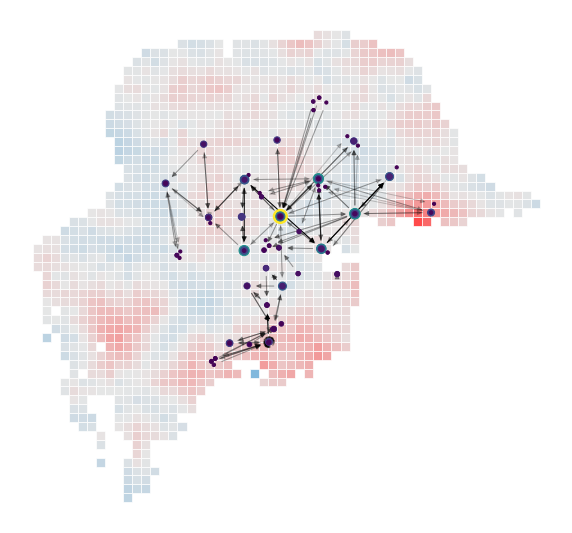

In [72]:
from matplotlib.colors import LinearSegmentedColormap

f,ax = plt.subplots(1,1,figsize=(10,10))

# 获取节点的位置信息
pos = nx.get_node_attributes(G, 'pos')
weights = list(nx.get_node_attributes(G, 'weight').values())
# 设置节点的大小范围
min_node_size = 10  # 最小节点大小
max_node_size = 200  # 最大节点大小
node_sizes = [min_node_size + (w - min(weights)) * (max_node_size - min_node_size) / (max(weights) - min(weights)) for w in weights]
node_colors = [w / max(weights) for w in weights] 

# 设置边的透明度范围
min_edge_alpha = 0.2  # 最小透明度
max_edge_alpha = 1.0  # 最大透明度
weights=nx.get_edge_attributes(G, 'weight').values()
edge_alphas = [min_edge_alpha + (w - min(weights)) * (max_edge_alpha - min_edge_alpha) / (max(weights) - min(weights)) for w in weights]


# 绘制图形
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='viridis', ax=ax)
edges = G.edges()
edges_without_self_loops = [edge for edge in edges if edge[0] != edge[1]]  # 排除自环边
nx.draw_networkx_edges(G, pos, edgelist=edges_without_self_loops, alpha=edge_alphas,arrows=True, ax=ax)

grid=gpd.read_file('../data/shp/nanshan_value/nanshan_value.shp')
# ax1=grid.plot(ax=ax,alpha=0.7,column='Join_Count', cmap='OrRd',vmin=-150,vmax=1200,edgecolor='white',linewidth=1)

colors = [(0, 120/255, 200/255),(220/255, 220/255, 220/255), (1, 0, 0)]  # 蓝色、灰色、红色
cmap_reverse = LinearSegmentedColormap.from_list('RdBu_reverse', colors, N=256)
ax1=grid.plot(ax=ax,alpha=0.7,column='states', vmin=4000, cmap=cmap_reverse,edgecolor='white',linewidth=1)
plt.axis('off')
plt.savefig('../img/cong_map.png',dpi=500)

# 3d-tda

In [73]:
# 加载地理数据
grid = gpd.read_file("../data/shp/nanshan_value/nanshan_value.shp")
[min_lon,min_lat,max_lon,max_lat] = grid.total_bounds 

fig, ax = plt.subplots(figsize=(20, 20))
colors = [(0, 120/255, 200/255),(220/255, 220/255, 220/255), (1, 0, 0)]  # 蓝色、灰色、红色
cmap_reverse = LinearSegmentedColormap.from_list('RdBu_reverse', colors, N=256)
grid.plot(ax=ax,alpha=0.5,column='states', vmin=4000, cmap=cmap_reverse,edgecolor='white',linewidth=1)
plt.axis('off')
plt.gca().invert_yaxis() 
plt.savefig("../img/geopandas_map.png", bbox_inches='tight', pad_inches=0, dpi = 10)
plt.close()

In [74]:
fig, ax = plt.subplots(figsize=(20, 20))
grid.plot(ax=ax,alpha=0.1)
plt.axis('off')
plt.gca().invert_yaxis() 
plt.savefig("../img/geopandas_map_alpha0.1.png", bbox_inches='tight', pad_inches=0, dpi = 10)
plt.close()

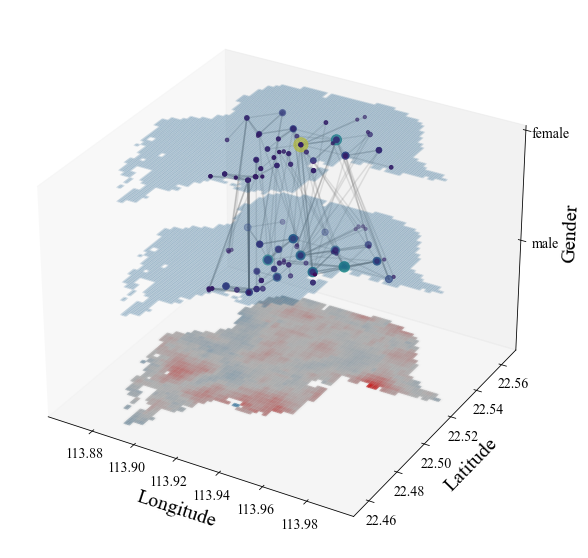

In [75]:
from matplotlib import image

min_node_size = 10
max_node_size = 200
min_edge_alpha = 0.2
max_edge_alpha = 1.0

# 准备3D绘图
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 在XY平面上添加底图
# 计算底图在XY平面上的位置和大小
map_img = image.imread('../img/geopandas_map.png')
x = np.linspace(min_lon, max_lon, num=map_img.shape[1])
y = np.linspace(min_lat, max_lat, num=map_img.shape[0])
x, y = np.meshgrid(x, y)
z = np.full(map_img.shape[:2], 0)  # 将底图置于略低于所有其他元素的位置
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=map_img)

alpha_img = image.imread('../img/geopandas_map_alpha0.1.png')
z2 = np.full(alpha_img.shape[:2], 1)  
z3 = np.full(alpha_img.shape[:2], 2)  
ax.plot_surface(x, y, z2, rstride=1, cstride=1, facecolors=alpha_img)
ax.plot_surface(x, y, z3, rstride=1, cstride=1, facecolors=alpha_img)


# 获取节点的位置信息和extra_attr
pos = nx.get_node_attributes(G, 'pos')  # 假设格式为{(node_id: (lng, lat))}
extra_attrs = nx.get_node_attributes(G, 'attr')  # 获取每个节点的Z轴值

# 计算节点大小和颜色
weights = list(nx.get_node_attributes(G, 'weight').values())
node_sizes_dict = {node: min_node_size + (weight - min(weights)) * (max_node_size - min_node_size) / (max(weights) - min(weights)) for node, weight in nx.get_node_attributes(G, 'weight').items()}
node_colors_dict = {node: (weight-min(weights)) / (max(weights)-min(weights)) for node, weight in nx.get_node_attributes(G, 'weight').items()}

# 准备x, y, z坐标和大小、颜色值的列表
x_values = [pos[node][0] for node in G.nodes()]
y_values = [pos[node][1] for node in G.nodes()]
z_values = [extra_attrs[node] for node in G.nodes()]
sizes = [node_sizes_dict[node] for node in G.nodes()]
colors = [node_colors_dict[node] for node in G.nodes()]
# 一次性绘制所有节点，应用颜色映射
ax.scatter(x_values, y_values, z_values, s=sizes, c=colors, cmap='viridis', depthshade=True)

# 绘制边
# 添加默认权重
for u, v, data in G.edges(data=True):
    if 'weight' not in data:
        G[u][v]['weight'] = 1  

edges = G.edges()
edge_colors = ['gray' for _ in edges]  # 如果边的颜色根据权重变化，这里也可以相应调整
weights=nx.get_edge_attributes(G, 'weight').values()
edge_alphas = [min_edge_alpha + (w - min(weights)) * (max_edge_alpha - min_edge_alpha) / (max(weights) - min(weights) + 0.001) for w in weights]

for edge, color, alpha in zip(edges, edge_colors, edge_alphas):
    start, end = edge
    x_start, y_start, z_start = (*pos[start], extra_attrs[start])
    x_end, y_end, z_end = (*pos[end], extra_attrs[end])
    ax.plot([x_start, x_end], [y_start, y_end], [z_start, z_end], color=color, alpha=alpha)

# fig信息
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.set_zlim(0, 2)
ax.grid(False)
ax.set_xlabel('Longitude',fontsize=20, fontname='Times New Roman',labelpad=10)
ax.set_ylabel('Latitude',fontsize=20, fontname='Times New Roman',labelpad=10)
ax.set_zlabel('Gender',fontsize=20, fontname='Times New Roman',labelpad=10)
ax.set_zticks([1, 2])
ax.set_zticklabels(['male', 'female'])

for t in ax.zaxis.get_major_ticks():
    t.set_pad(7)  # 'pad'是刻度与标签之间的距离，可以根据需要调整这个值

for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
    label.set_fontname('Times New Roman')
    label.set_fontsize(14)  # 调整刻度标签大小

# plt.savefig('../img/cong_map_3d.png',dpi=500)
plt.show()